# Mars: solar occultation with AOTF spectrometer

In this example, we show how archNEMESIS can be used to calculate forward models for solar occultation measurements made with spectrometers that combine an echelle grating for high-resolution spectroscopy, together with an acousto-optic tunable filter (AOTF) for the separation of diffraction orders. Specifically, we are going to model spectral signatures of CO$_2$ in a spectral range between $\sim$6500-7000 cm$^{-1}$.

In [1]:
import archnemesis as ans
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## 1. Input files

In [2]:
runname = 'acsnir_fm'

#Reading the input files
Atmosphere,Measurement,Spectroscopy,Scatter,Stellar,Surface,CIA,Layer,Variables,Retrieval,Telluric = ans.Files.read_input_files_hdf5(runname)

INFO :: read_apr :: Variables_0.py-823 :: 
Variables_0 :: read_apr :: varident [1 0 2]. Constructed model "Model2" (id=2)
INFO :: read_apr :: Variables_0.py-826 ::   Model2:
  |- id : 2
  |- parent classes: PreRTModelBase
  |- description: In this model, the atmospheric parameters are scaled using a
  |               single factor with  respect to the vertical profiles in the
  |               reference atmosphere
  |- n_state_vector_entries : 1
  |- state_vector_slice : slice(0, 1, None)
  |- state_vector_start : 0
  |- target : 0
  |- Parameters:
  |  |- scaling_factor :
  |  |  |- slice : slice(0, 1, None)
  |  |  |- unit : PROFILE_TYPE
  |  |  |- description: Scaling factor applied to the reference profile
  |  |  |- apriori value : 1.0


## 2. Introduction to the AOTF filter function

The AOTF of the instrument is, as it name suggests, a tunable filter characterised by a given filter function. In the ideal case, the transmission of the filter is 100% for the free spectral range of the grating, which defines the spectral separation between two successive diffraction orders, and 0% elsewhere. However, in reality, the transmission of the AOTF filter might have sidelobes that allow light from other diffraction orders to go through the filter. As a consequence of this, the light collected on the detector is a combination of diffraction orders weighted by the transmission function.

In order to illustrate this, below we show an example of a realistic AOTF filter function, highlighting the wavenumber array of the main and the adjacent orders. 

In [3]:
#Ideal filter function
###########################################################################################################

center_wavenumber = Measurement.VCONV[int(Measurement.NCONV[0]/2),0]  # cm^-1
target_fwhm = 120.0         # desired main lobe FWHM in cm^-1
num_points = 4000

wavenumbers = np.linspace(center_wavenumber - 400, center_wavenumber + 400, num_points)

aotf_ideal = np.zeros(num_points)
aotf_ideal[ (wavenumbers>=center_wavenumber-target_fwhm/2) & (wavenumbers<=center_wavenumber+target_fwhm/2) ] = 1.


# AOTF function modelled as a sinc function
#######################################################################################

# Relation between FWHM and sinc width
width_parameter = target_fwhm / 0.885

# Base sinc² profile
sinc_arg = (wavenumbers - center_wavenumber) / (width_parameter / 2.0)
transmission = np.sinc(sinc_arg) ** 2
transmission /= np.max(transmission)

# Estimate first side-lobe amplitude (for sinc² it's about 0.047)
avg_sidelobe = 0.047
desired_sidelobe = 0.1
s = desired_sidelobe / avg_sidelobe  # scale factor for far wings

# Smooth Gaussian-like envelope to enhance lobes
delta_zero = width_parameter / 2.0
sigma_env = delta_zero
envelope = s + (1.0 - s) * np.exp(-((wavenumbers - center_wavenumber) / sigma_env)**2)

# Apply envelope and renormalise
aotf_sinc = transmission * envelope
aotf_sinc /= np.max(aotf_sinc)

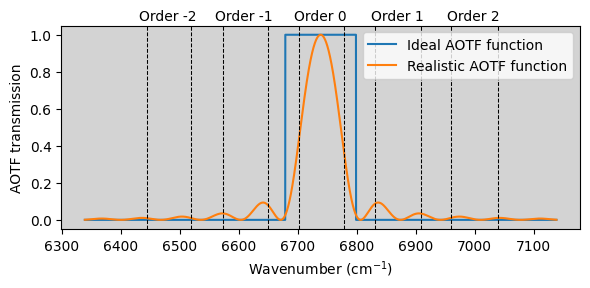

In [4]:
fig,ax1 = plt.subplots(1,1,figsize=(6,3))

ax1.plot(wavenumbers,aotf_ideal,label='Ideal AOTF function')
ax1.plot(wavenumbers,aotf_sinc,label='Realistic AOTF function')

labels = ["-2","-1","0","1","2"]
for i in range(Measurement.NORDERS_AOTF):
    ax1.axvline(Measurement.VCONV_AOTF[0,0,i],c='black',linewidth=0.75,linestyle='--')
    ax1.axvline(Measurement.VCONV_AOTF[-1,0,i],c='black',linewidth=0.75,linestyle='--')

    ax1.text(Measurement.VCONV_AOTF[int(Measurement.NCONV[0]/2),0,i], 1.1, 'Order '+labels[i], horizontalalignment='center',
         verticalalignment='center')

ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('AOTF transmission')
ax1.set_facecolor('lightgray')
ax1.legend()
plt.tight_layout()


## 3. Defining the AOTF filter function in archNEMESIS

ArchNEMESIS allows the combination of spectra from different diffraction orders, mimicking the instrumental response of an instrument combining an AOTF filter with an echelle grating.

The main parameters that need to be defined are:
- NORDERS_AOTF: Indicates the number of diffraction orders that need to be included. This number will depend on how far from the central wavelength the AOTF filter function extends to.
- VCONV_AOTF: This indicates the convolution wavelengths or wavenumbers for each of the diffraction orders. The shape of this array must be (NCONV,NGEOM,NORDERS_AOTF). Note that NCONV must be the same size for all diffraction orders.
- TRANS_AOTF: This indicates the transmission of the AOTF filter for each of the convolution wavelengths or wavenumbers.

In order to illustrate this, we are going to use the AOTF filter function from the previous section and adapt it to the diffraction orders specified in the input files. We are going to create two cases, one with the ideal AOTF function, and one with the realistic one.

In [5]:
Measurement_ideal = deepcopy(Measurement)
Measurement_sinc = deepcopy(Measurement)

In [6]:
trans_aotf_ideal = np.zeros((Measurement.NCONV.max(),Measurement.NGEOM,Measurement.NORDERS_AOTF))
trans_aotf_sinc = np.zeros((Measurement.NCONV.max(),Measurement.NGEOM,Measurement.NORDERS_AOTF))
for iorder in range(Measurement.NORDERS_AOTF):

    #Interpolating AOTF filter function to the diffraction orders
    trans_aotfx = np.interp(Measurement.VCONV_AOTF[:,0,iorder],wavenumbers,aotf_sinc)
    trans_aotf_sinc[:,:,iorder] = trans_aotfx[:,np.newaxis]

    trans_aotfx = np.interp(Measurement.VCONV_AOTF[:,0,iorder],wavenumbers,aotf_ideal)
    trans_aotf_ideal[:,:,iorder] = trans_aotfx[:,np.newaxis]

Measurement_ideal.TRANS_AOTF = trans_aotf_ideal
Measurement_ideal.assess()

Measurement_sinc.TRANS_AOTF = trans_aotf_sinc
Measurement_sinc.assess()

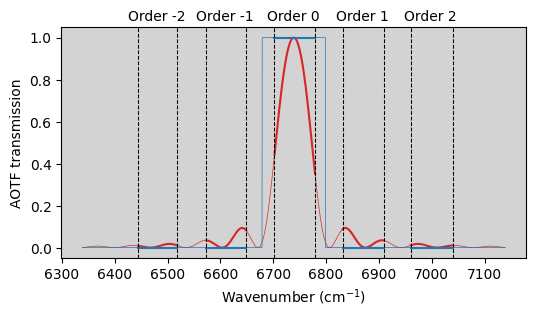

In [7]:
fig,ax1 = plt.subplots(1,1,figsize=(6,3))

ax1.plot(wavenumbers,aotf_sinc,label='Realistic AOTF function',linewidth=0.5,c='tab:red')
ax1.plot(wavenumbers,aotf_ideal,label='Ideal AOTF function',linewidth=0.5,c='tab:blue')

labels = ["-2","-1","0","1","2"]
for i in range(Measurement.NORDERS_AOTF):
    ax1.plot(Measurement_sinc.VCONV_AOTF[:,0,i],Measurement_sinc.TRANS_AOTF[:,0,i],c='tab:red')
    ax1.plot(Measurement_ideal.VCONV_AOTF[:,0,i],Measurement_ideal.TRANS_AOTF[:,0,i],c='tab:blue')
    ax1.axvline(Measurement.VCONV_AOTF[0,0,i],c='black',linewidth=0.75,linestyle='--')
    ax1.axvline(Measurement.VCONV_AOTF[-1,0,i],c='black',linewidth=0.75,linestyle='--')

    ax1.text(Measurement.VCONV_AOTF[int(Measurement.NCONV[0]/2),0,i], 1.1, 'Order '+labels[i], horizontalalignment='center',
         verticalalignment='center')

ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('AOTF transmission')
ax1.set_facecolor('lightgray')

## 4. Calculating forward model

Once we have correctly defined the AOTF filter function into the Measurement class, we can compute the spectra for a solar occultation measurement just as if we were not including any AOTF function at all.

In order to reconstruct the AOTF filter function, the spectra for each of the diffraction orders is weighted based on their AOTF transmissions. Then, the combined spectra is normalised. Mathematically, this is expressed as:


$$
R(\lambda) = \dfrac{\sum_{i=1}^{NORDERS} R_i(\lambda) \, T_{AOTF_i}(\lambda)}{\sum_{i=1}^{NORDERS} T_{AOTF_i}(\lambda)}
$$


In [8]:
#Running forward model for ideal AOTF function
ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement_ideal,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV_ideal = ForwardModel.nemesisSOfm()

#Running forward model for sinc AOTF function
ForwardModel = ans.ForwardModel_0(runname=runname, Atmosphere=Atmosphere,Surface=Surface,Measurement=Measurement_sinc,Spectroscopy=Spectroscopy,Stellar=Stellar,Scatter=Scatter,CIA=CIA,Layer=Layer,Variables=Variables)
SPECONV_sinc = ForwardModel.nemesisSOfm()

INFO :: __init__ :: ForwardModel_0.py-255 :: Checking atmospheric gasses have spectroscopy data.
# WARNING #########################################################################

The following atmospheric gasses ARE NOT PRESENT in the spectroscopy data and WILL NOT CONTRIBUTE TO OPACITY:

    H2O (id 1) isotopologue 0
    N2 (id 22) isotopologue 0
    Ar (id 76) isotopologue 0
    CO (id 5) isotopologue 0
    O (id 45) isotopologue 0
    O2 (id 7) isotopologue 0
    O3 (id 3) isotopologue 0
    H (id 48) isotopologue 0
    H2 (id 39) isotopologue 0
    He (id 40) isotopologue 0
    CO2 (id 2) isotopologue 3
    CO2 (id 2) isotopologue 4

To deactivate this warning place a path to a line-by-line-table file for these gasses in one of the following locations (depending upon your input file type):

    [HDF5 Input]
        In the "acsnir_fm.h5" file, add an entry to "/Spectroscopy/LOCATION"
        and update "/Spectroscopy/NGAS" appropriately.

    [LEGACY Input]
        Add an entry t

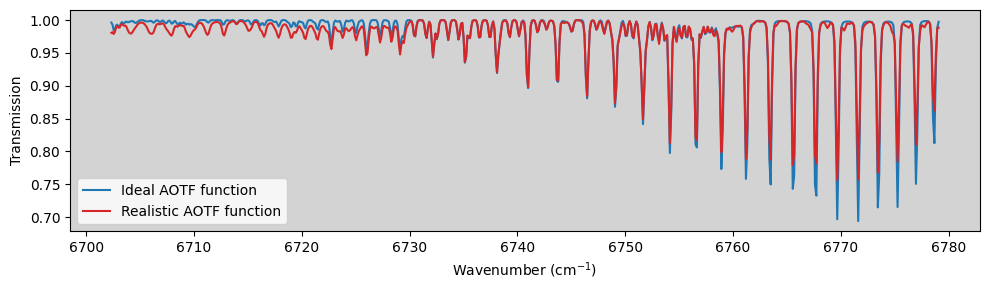

In [13]:
igeom = 0

fig,ax1 = plt.subplots(1,1,figsize=(10,3))

ax1.plot(Measurement.VCONV[:,igeom],SPECONV_ideal[:,igeom],c='tab:blue',label='Ideal AOTF function')
ax1.plot(Measurement.VCONV[:,igeom],SPECONV_sinc[:,igeom],c='tab:red',label='Realistic AOTF function')
ax1.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax1.set_ylabel('Transmission')
ax1.set_facecolor('lightgray')
ax1.legend()
plt.tight_layout()
